# ***Deep Learning based Car Identification***
##### *- Automotive, Surveillance, Object Detection & Localisation*

***Project By:***<br>
Premjeet Kumar https://www.linkedin.com/in/premjeet-kumar/<br>
Hari Samynaath S https://www.linkedin.com/in/harinaathan/<br>
Veena Raju https://www.linkedin.com/in/veena-raju-1b16b513b/<br>
Javed Bhai https://www.linkedin.com/in/javedbhai/<br>
Surabhi Joshi https://www.linkedin.com/in/surabhi-joshi-4452788/<br>

***Project For:***<br>
Captstone project for **Post Graduate Program in Artificial Intelligence and Machine Learning**<br>
with *GreatLakes & Texas McCombs School of Business, The University of Texas at Austin*

**CONTEXT:**<br>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is predicted from the image of interest. For example a car moving on the road can be easily identi ied by a camera as make of the car, type, colour, number plates etc.<br><br>
**DATA DESCRIPTION:**<br>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.<br>
<br>
‣ *Train Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Test Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Train Annotation:* Consists of bounding box region for training images.<br>
‣ *Test Annotation:* Consists of bounding box region for testing images.<br>

### **MILESTONE 1:**
‣ *Step 1:* Import the data<br>
‣ *Step 2:* Map training and testing images to its classes.<br>
‣ *Step 3:* Map training and testing images to its annotations.<br>
‣ *Step 4:* Display images with bounding box<br>
‣ *Output:* Images mapped to its class and annotation ready to be used for deep learning<br>

### **MILESTONE 2:**
‣ *Input:* Output of milestone 1<br>
‣ *Step 1:* Design, train and test CNN models to classify the car.<br>
‣ *Step 2:* Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or
mask over the area of interest.<br>
‣ *Output:* Pickled model to be used for future prediction<br>

In [1]:
from lib.networkPipe import mReport
from lib.extract import trainDF, testDF

2022-07-26 04:57:25.497369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 04:57:25.524115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 04:57:25.524279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 04:57:25.524972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### strategic goals
The goal of the model training is to achieve the best knowledge from the available dataset<br>
In the process, it should be taken care that the model doesn't overfit to the learning dataset<br>
That is like memorizing the answers to multiplication tables in sequence without understanding the underlying addition logics<br>
Hence we will ensure that the model generalizes in learning, at trade-off in accuracy<br>
But how much trade-off is acceptable?<br>
To answer that, we will consider 2 unlearned models<br>
1. A model that will predict
    a. all datapoints as the mode of the target class distribution and/or
    b. all datapoints will yield a value equal to the median of the target value distribution
2. A model that will predict in random, well within the available limits & distribution of target class/values<br>

criteria: any learned model must be able to perform better than these two unlearned models<br>
the above criteria sets the baseline for any learned model

### model trial 1 - Mode & Median

,modelName,loss,names_loss,boxes_loss,names_accuracy,names_precision,names_recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_accuracy,val_names_precision,val_names_recall,val_boxes_IoU
0,Mode_&_Mean,67718.842398,15.983514,67702.858884,0.00835,0.00835,0.00835,0.369313,68264.161681,15.98179,68248.179891,0.008457,0.008457,0.008457,0.371899


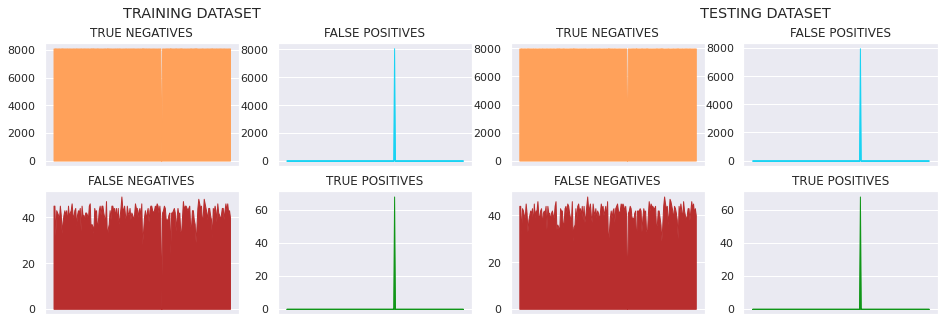

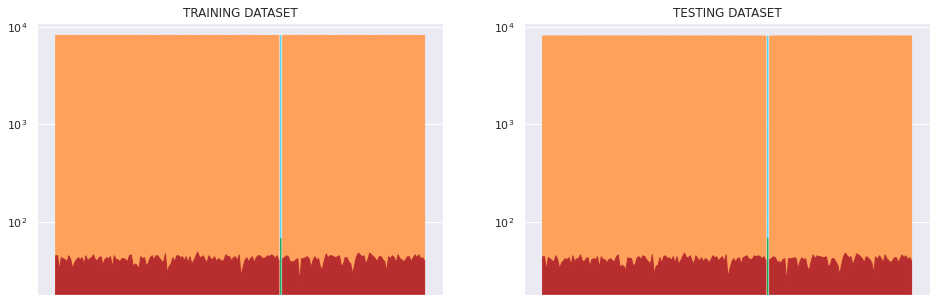

samples from TRAINING SET


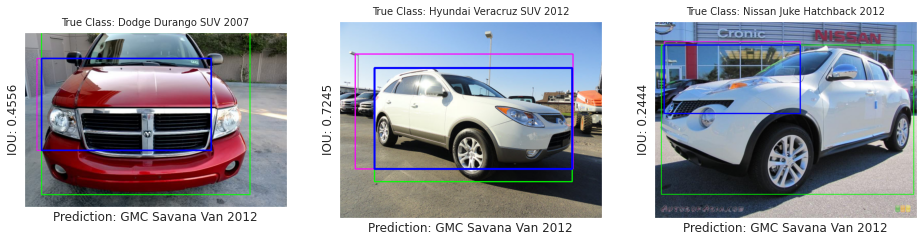

samples from TESTING SET


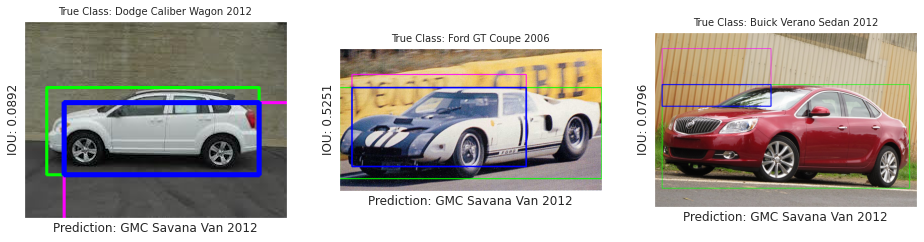

In [2]:
import numpy as np
import tensorflow as tf
import os, pickle
from sklearn.preprocessing import LabelBinarizer

# Random consistency seed
np.random.seed(100)
tf.random.set_seed(100)

# mode of class names
classMode = trainDF.className.value_counts().sort_values(ascending=False).index[0]
# true & predicted class names
enc = LabelBinarizer()
trueY = enc.fit_transform(trainDF.className.values.reshape(-1,1))/1.0
# prediction full of Modes
predY = enc.transform(np.array([classMode]*len(trainDF.className.values)).reshape(-1,1))/1.0

# image size matrix
imSizeTrain = trainDF[["width","height","width","height"]].values*1.0

# compute median predictions of bounding boxes
trueYbox = trainDF[["x1","y1","x2","y2"]].values*1.0
trueYbox = tf.divide(trueYbox,imSizeTrain)
predYbox = np.empty_like(trueYbox)
predYbox[:] = trainDF[["x1","y1","x2","y2"]].median().values*1.0
predYbox = tf.divide(predYbox,imSizeTrain)

# predict on test dataset
testY = enc.transform(testDF.className.values.reshape(-1,1))/1.0
predTestY = enc.transform(np.array([classMode]*len(testDF.className.values)).reshape(-1,1))/1.0

# image size matrix
imSizeTest = testDF[["width","height","width","height"]].values*1.0

# compute median predictions of bounding boxes
testYbox = testDF[["x1","y1","x2","y2"]].values
testYbox = tf.divide(testYbox,imSizeTest)
predTestYbox = np.empty_like(testYbox)
predTestYbox[:] = trainDF[["x1","y1","x2","y2"]].median().values
predTestYbox = tf.divide(predTestYbox,imSizeTest)

# generate evaluation report on this model
evalResult = mReport("Mode_&_Mean", # model name
                     trainDF.ImagePath.values, # training image path
                     [trueY,predY,np.multiply(trueYbox,imSizeTrain).astype(int),
                      np.multiply(predYbox,imSizeTrain).astype(int)], # results of prediction in training dataset
                     testDF.ImagePath.values, # testing image path
                     [testY,predTestY,np.multiply(testYbox,imSizeTest).astype(int),
                      np.multiply(predTestYbox,imSizeTest).astype(int)], # results of prediction in testing dataset
                     enc # label encoder instance
                    )

path = os.path.join('.',"deployables")
try:
    os.listdir(path)
except:
    os.mkdir(path)
path = os.path.join(path,"Mode_&_Mean")
try:
    os.rmdir(path)
    os.mkdir(path)
except:
    try:
        os.mkdir(path)
    except:
        pass
fname = os.path.join(path,"%s_attrib.gl"%"Mode_&_Mean")
attribNames = ['evalResults']
attributes = [evalResult]
with open(fname, 'wb') as fh:
    pickle.dump(dict(zip(attribNames,attributes)), fh)

### model trial 2 - random prediction

,modelName,loss,names_loss,boxes_loss,names_accuracy,names_precision,names_recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_accuracy,val_names_precision,val_names_recall,val_boxes_IoU
0,Random,56141.459479,16.01716,56125.442319,0.006262,0.006262,0.006262,0.135558,56291.900458,16.015867,56275.884591,0.006342,0.006342,0.006342,0.133105


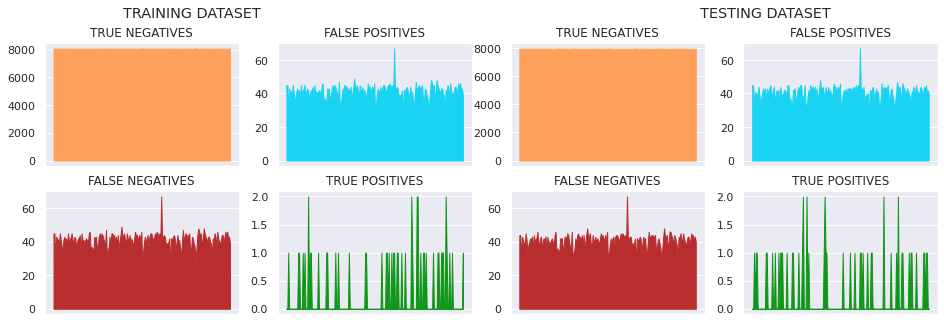

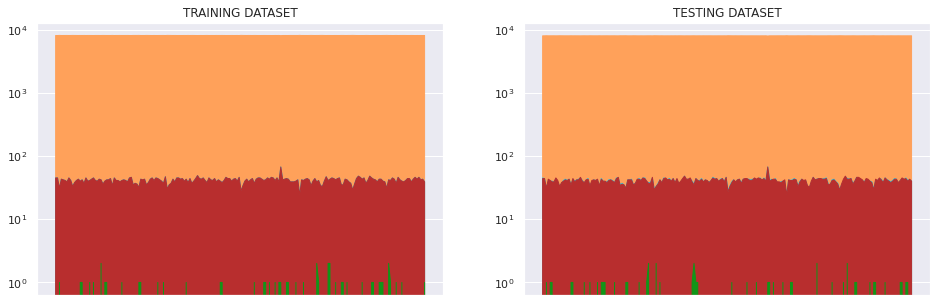

samples from TRAINING SET


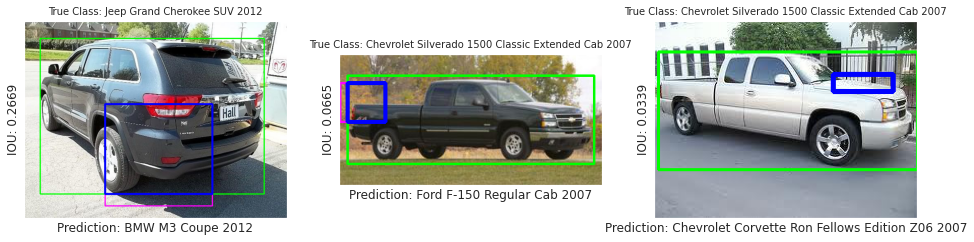

samples from TESTING SET


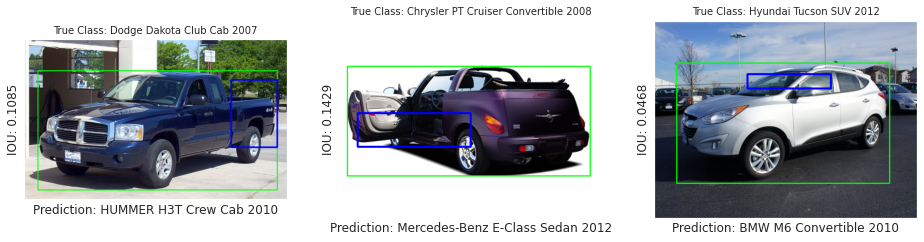

In [3]:
# Random consistency seed
np.random.seed(100)
tf.random.set_seed(100)

# true & predicted class names
enc = LabelBinarizer()
trueY = enc.fit_transform(trainDF.className.values.reshape(-1,1))/1.0
# prediction of random classes
predY = enc.transform(np.random.choice(trainDF.className.values,trainDF.shape[0],replace=False).reshape(-1, 1))/1.0

# image size matrix
imSizeTrain = trainDF[["width","height","width","height"]].values*1.0

# true boxes
trueYbox = trainDF[["x1","y1","x2","y2"]].values*1.0
trueYbox = tf.divide(trueYbox,imSizeTrain)
# random box predictions
x = np.sort(np.random.rand(trueYbox.shape[0],2),axis=1)
y = np.sort(np.random.rand(trueYbox.shape[0],2),axis=1)
predYbox = np.array((x[:,0],y[:,0],x[:,1],y[:,1])).transpose()

# predict on test data
testY = enc.transform(testDF.className.values.reshape(-1,1))/1.0
predTestY = enc.transform(np.random.choice(trainDF.className.values,testDF.shape[0],replace=False).reshape(-1, 1))/1.0

# image size matrix
imSizeTest = testDF[["width","height","width","height"]].values*1.0

# true boxes
testYbox = testDF[["x1","y1","x2","y2"]].values
testYbox = tf.divide(testYbox,imSizeTest)
# random box predictions
x = np.sort(np.random.rand(testYbox.shape[0],2),axis=1)
y = np.sort(np.random.rand(testYbox.shape[0],2),axis=1)
predTestYbox = np.array((x[:,0],y[:,0],x[:,1],y[:,1])).transpose()

# generate evaluation report on this model
evalResult = mReport("Random", # model name
                     trainDF.ImagePath.values, # training image path
                     [trueY,predY,np.multiply(trueYbox,imSizeTrain).astype(int),
                      np.multiply(predYbox,imSizeTrain).astype(int)], # results of prediction in training dataset
                     testDF.ImagePath.values, # testing image path
                     [testY,predTestY,np.multiply(testYbox,imSizeTest).astype(int),
                      np.multiply(predTestYbox,imSizeTest).astype(int)], # results of prediction in testing dataset
                     enc # label encoder instance
                    )

path = os.path.join('.',"deployables")
try:
    os.listdir(path)
except:
    os.mkdir(path)
path = os.path.join(path,"Random")
try:
    os.rmdir(path)
    os.mkdir(path)
except:
    try:
        os.mkdir(path)
    except:
        pass
fname = os.path.join(path,"%s_attrib.gl"%"Random")
attribNames = ['evalResults']
attributes = [evalResult]
with open(fname, 'wb') as fh:
    pickle.dump(dict(zip(attribNames,attributes)), fh)